<h2><center> Welcome to the Faulty Air-Quality Sensor Challenge</h2></center>
<figure>
<center><img src ="https://drive.google.com/uc?export=view&id=1hSOAfRhJ_jo-MZAjq81VYJu5bZNL7EjD" width = "800" height = '500'/>

*About the problem*
> AirQo’s air quality sensing network has more than 120 low-cost devices deployed across Uganda; in most cases, these devices are deployed in unmonitored or perilous environments. These low-cost electronic devices are susceptible to breakdown caused by communication malfunction, aging, wear and tear, manufacturing deficiencies, incorrect calibration, mishandling and other external environmental factors. Faults lead to data inaccuracies and data loss, which impacts decisions and policies that could significantly impact people’s lives. 

*Objective of this challenge*
> In this challenge, your task is to develop a binary clasification model to identify faulty sensors, regardless of the device type. The model will be used by AirQo to automatically flag devices that have faulty readings. 

Device failure detection and monitoring is critical to AirQo’s work; faulty devices need to be identified, isolated and fixed or replaced with urgency



## Table of contents:

1. [Importing libraries](#Libraries)
2. [Loading data](#Data)
3. [Statistical summaries](#Statistics)
4. [Missing values and duplicates](#Missing)
5. [Outliers](#Outliers)
6. [Feature engineering](#Engineering)
7. [Date features EDA](#Dates)
8. [Correlations - EDA](#Correlations)
9. [Preprocess test dataset](#Preprocess)
10. [Modelling](#Modelling)
11. [Making predictions of the test set and creating a submission file](#Predictions)
12. [TO DOs](#Tips)

<a name="Libraries"></a>
## 1. Importing libraries


In [341]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
pd.options.display.float_format = '{:.5f}'.format

# CatBoost
from catboost import CatBoostClassifier

# LightGBM
# from lightgbm import LGBMClassifier

# SMOTE
from imblearn.over_sampling import SMOTE

# Logistic Regression
from sklearn.linear_model import LogisticRegression

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

<a name="Data"></a>
## 2. Loading data

In [288]:
# Load files
train = pd.read_csv('datasets/train.csv', parse_dates = ['Datetime'])
test = pd.read_csv('datasets/test.csv', parse_dates = ['Datetime'])
samplesubmission = pd.read_csv('datasets/SampleSubmission.csv')

# Preview train dataset
train.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
0,ID_QF0ZTQJ2SF5Q,2021-11-03 04:06:31,52.58000,49.52000,17.40000,96.00000,0
1,ID_4GTK689CNX5S,2021-11-08 18:43:23,35.25000,33.40000,25.00000,75.00000,0
2,ID_DL7VVKW9U7XQ,2021-11-07 09:50:33,19.18000,23.50000,24.90000,75.00000,0
3,ID_6XQOMBXM2DG3,2022-01-01 18:55:15,19.40000,15.48000,24.90000,70.00000,0
4,ID_UQZW9ISJY9QE,2021-11-05 22:23:48,38.30000,34.77000,20.90000,89.00000,0


In [289]:
# Preview test dataset
test.head()

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75000,114.78000,22.20000,56.00000
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03000,52.18000,NaN,NaN
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35000,346.73000,28.10000,63.00000
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17000,83.85000,21.60000,82.00000
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23000,53.07000,22.70000,80.00000


In [290]:
# Preview sample submission file
samplesubmission.head()

,ID,Offset_fault
0,ID_STL3V9B2OU12,0
1,ID_U2EKAY4SGA94,0
2,ID_UJFLEWQR0U4N,0
3,ID_S2C2GPGA4R5I,0
4,ID_5V2C2ZL221H8,0


In [291]:
# Check size and shape of datasets
train.shape, test.shape, samplesubmission.shape

((297177, 7), (127361, 6), (127361, 2))

In [292]:
# print(train.columns)
# print(test.columns)

<a name="Statistics"></a>
## 3. Statistical summaries

In [293]:
# Train statistical summary
train.describe(include = 'all')

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Offset_fault
count,297177,297177,293563.00000,293563.00000,293628.00000,293628.00000,297177.00000
unique,297177,293751,NaN,NaN,NaN,NaN,NaN
top,ID_V99ZE5G6MPGA,2021-12-06 02:28:52,NaN,NaN,NaN,NaN,NaN
freq,1,3,NaN,NaN,NaN,NaN,NaN
first,NaN,2021-10-15 16:00:31,NaN,NaN,NaN,NaN,NaN
last,NaN,2022-01-21 07:34:57,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,40.75120,38.18302,23.31655,78.65362,0.37107
std,NaN,NaN,28.52618,28.64776,3.83697,14.77272,0.48309
min,NaN,NaN,-9.45000,-9.70000,16.70000,27.00000,0.00000
25%,NaN,NaN,22.43000,19.52000,20.40000,68.00000,0.00000


From the above statistical summary, we can deduce some of the following insights:
 - The train data provided ranges from *2021-10-15 16:00:34* to *2022-01-21 07:34:57*
 - There is a high correlation between Sensor1_PM2.5	and Sensor2_PM2.5
 - Minimum recorded temperature is *16.70000* and a maximum *34.90000*

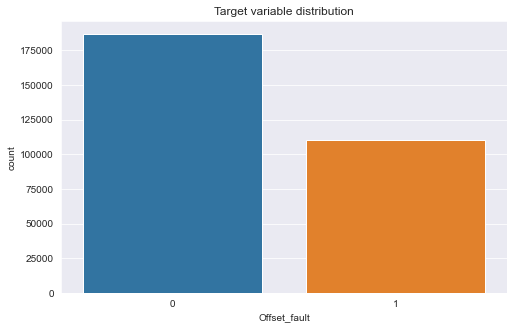

In [294]:
# Target variable distribution
sns.set_style('darkgrid')
plt.figure(figsize=(8, 5))
sns.countplot(train["Offset_fault"])
plt.title('Target variable distribution')
plt.show()

The target variable is not well balanced.
Some of the techniques to handle imbalanceness include:
- Smote
- Oversampling
- Undersampling ...

<a name="Missing"></a>
## 4. Missing values and duplicates

In [295]:
# Check for missing values
train.isnull().sum().any(), test.isnull().sum().any()

(True, True)

In [296]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297177 entries, 0 to 297176
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   ID                 297177 non-null  object        
 1   Datetime           297177 non-null  datetime64[ns]
 2   Sensor1_PM2.5      293563 non-null  float64       
 3   Sensor2_PM2.5      293563 non-null  float64       
 4   Temperature        293628 non-null  float64       
 5   Relative_Humidity  293628 non-null  float64       
 6   Offset_fault       297177 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 15.9+ MB


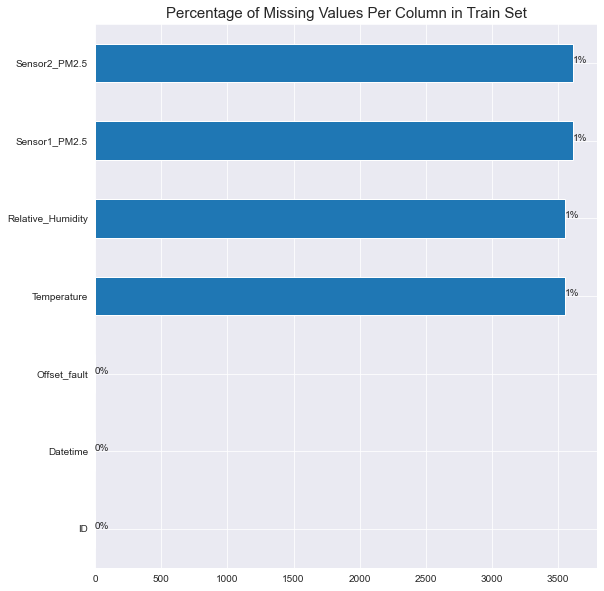

In [297]:
# Plot missing values in train set
ax = train.isna().sum().sort_values().plot(kind = 'barh', figsize = (9, 10))
plt.title('Percentage of Missing Values Per Column in Train Set', fontdict={'size':15})
for p in ax.patches:
    percentage ='{:,.0f}%'.format((p.get_width()/train.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

Suggestions on how to handle missing values:
 - Fill in missing values with mode, mean, median..
 - Drop Missing datapoints with missing values
 - Fill in with a large number e.g -999999

In [298]:
# Fill missing values with mode
# train = train.fillna(0)
# fts = ['Sensor1_PM2.5','Sensor2_PM2.5', 'Temperature', 'Relative_Humidity']
#
# for ft in fts:
#     train[ft].fillna(train[ft].mode()[0], inplace=True)

In [299]:
# Check for duplicates
train.duplicated().any(), test.duplicated().any()

(False, False)

No duplictes 

<a name="Outliers"></a>
## 5. Outliers

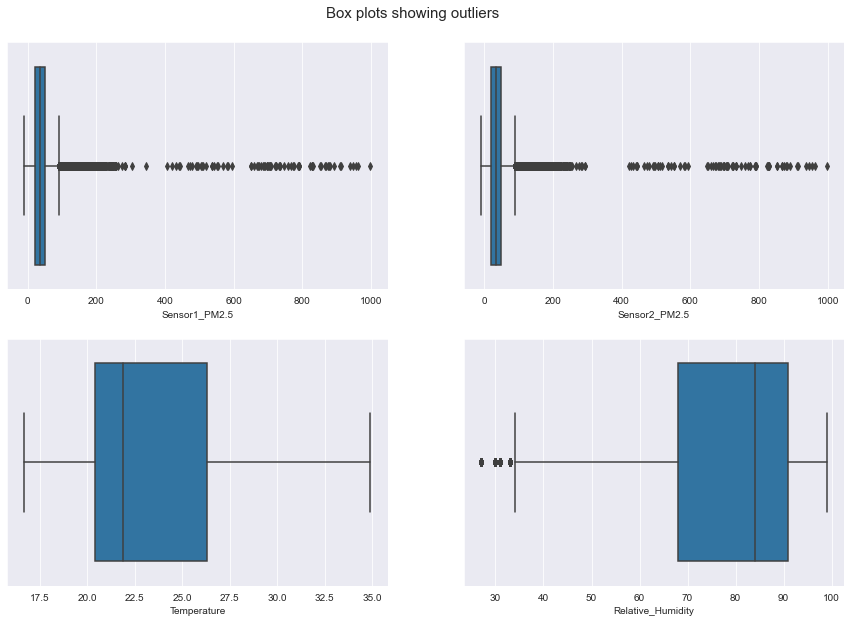

In [300]:
# Plotting boxplots for each of the numerical columns
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (15, 10))
fig.suptitle('Box plots showing outliers', y= 0.93, fontsize = 15)

for ax, data, name in zip(axes.flatten(), train, ['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity']):
  sns.boxplot(train[name], ax = ax)

Outliers are those data points which differs significantly from other observations present in given dataset.

Suggestions on how to handle outliers:
 - Transforming the outliers by scaling - log transformation, box-cox transformation ...
 - Dropping outliers
 - Imputation by replacing outliers with mean, median ...


<a name="Engineering"></a>
## 6. Feature engineering

In [319]:
# data transformation
datasets = [train, test]
# cols_drop = ['Temperature', 'Relative_Humidity']

for dataset in datasets:
    dataset['Datetime_day'] = dataset.Datetime.dt.day
    # month
    dataset['Datetime_month'] = dataset.Datetime.dt.month

    # year
    dataset['Datetime_year'] = dataset.Datetime.dt.year

    # hour
    dataset['Datetime_hour'] = dataset.Datetime.dt.hour

    # added these 4 columns to the dataset
    # day of week
    dataset['Datetime_dayofweek'] = dataset.Datetime.dt.dayofweek

    # week of year
    dataset['Datetime_weekofyear'] = dataset.Datetime.dt.weekofyear

    # mean temperature
    dataset['Temperature_mean'] = dataset.groupby('Datetime_day')['Temperature'].transform('mean')

    # mean relative humidity
    dataset['Relative_Humidity_mean'] = dataset.groupby('Datetime_day')['Relative_Humidity'].transform('mean')

    # drop temperature and humidity
    # dataset.drop(cols_drop, inplace=True, axis=1)

    # fill missing values if any (with mode)
    for col in dataset.columns:
        dataset[col].fillna(dataset[col].mode()[0], inplace=True)

print(len(train.columns), len(test.columns))

train.columns, test.columns
# train.columns.value_counts()

15 14


(Index(['ID', 'Datetime', 'Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature',
        'Relative_Humidity', 'Offset_fault', 'Datetime_day', 'Datetime_month',
        'Datetime_year', 'Datetime_hour', 'Datetime_dayofweek',
        'Datetime_weekofyear', 'Temperature_mean', 'Relative_Humidity_mean'],
       dtype='object'),
 Index(['ID', 'Datetime', 'Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature',
        'Relative_Humidity', 'Datetime_day', 'Datetime_month', 'Datetime_year',
        'Datetime_hour', 'Datetime_dayofweek', 'Datetime_weekofyear',
        'Temperature_mean', 'Relative_Humidity_mean'],
       dtype='object'))

In [320]:
test

,ID,Datetime,Sensor1_PM2.5,Sensor2_PM2.5,Temperature,Relative_Humidity,Datetime_day,Datetime_month,Datetime_year,Datetime_hour,Datetime_dayofweek,Datetime_weekofyear,Temperature_mean,Relative_Humidity_mean
0,ID_STL3V9B2OU12,2022-01-28 08:49:41,90.75000,114.78000,22.20000,56.00000,28,1,2022,8,4,4,23.01266,71.89697
1,ID_U2EKAY4SGA94,2022-02-16 21:30:17,56.03000,52.18000,21.00000,92.00000,16,2,2022,21,2,7,21.00000,92.00000
2,ID_UJFLEWQR0U4N,2022-01-24 17:57:18,387.35000,346.73000,28.10000,63.00000,24,1,2022,17,0,4,22.92780,82.60872
3,ID_S2C2GPGA4R5I,2022-01-31 07:07:09,63.17000,83.85000,21.60000,82.00000,31,1,2022,7,0,5,22.23156,81.77883
4,ID_5V2C2ZL221H8,2022-01-31 00:37:05,69.23000,53.07000,22.70000,80.00000,31,1,2022,0,0,5,22.23156,81.77883
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127356,ID_HNCS9Q2GNCQB,2022-02-13 00:37:14,33.65000,42.23000,21.00000,92.00000,13,2,2022,0,6,6,21.00000,92.00000
127357,ID_GIIQYTE11L3H,2022-03-09 16:26:42,21.23000,15.72000,21.00000,92.00000,9,3,2022,16,2,10,21.00000,92.00000
127358,ID_EC7F1P4GXKCL,2022-02-18 14:47:28,41.45000,47.25000,21.00000,92.00000,18,2,2022,14,4,7,21.00000,92.00000
127359,ID_J64RVG2BRAG0,2022-03-11 19:14:11,28.60000,27.27000,21.00000,92.00000,11,3,2022,19,4,10,21.00000,92.00000


In [303]:
# # Extract day, month year and hour from the Datetime column
# # day
# train['Datetime_day'] = train.Datetime.dt.day
#
# # month
# train['Datetime_month'] = train.Datetime.dt.month
#
# # year
# train['Datetime_year'] = train.Datetime.dt.year
#
# # hour
# train['Datetime_hour'] = train.Datetime.dt.hour
#
# # day of week
# train['Datetime_dayofweek'] = train.Datetime.dt.dayofweek
#
# # week of year
# train['Datetime_weekofyear'] = train.Datetime.dt.weekofyear

# Preview engineered date features


<a name="Dates"></a>
## 7. Date features EDA

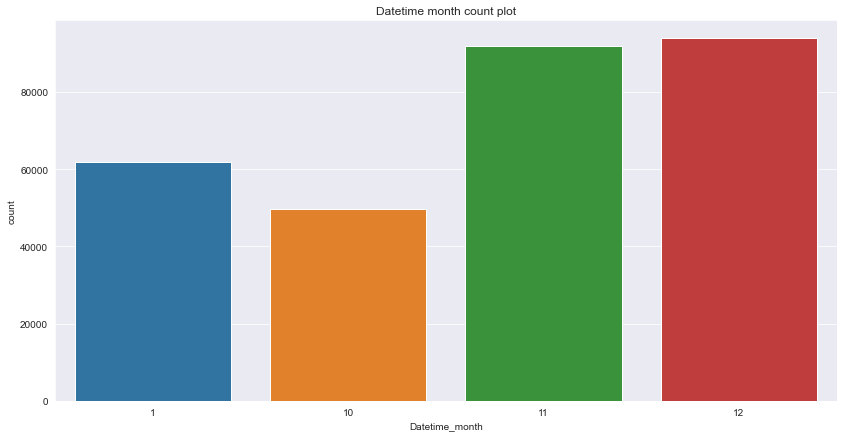

In [321]:
# Datetime month countplot
plt.figure(figsize = (14, 7))
sns.countplot(x = 'Datetime_month', data = train)
plt.title('Datetime month count plot')
plt.show()

- The only months available in the train set include *Jan, Oct, Nov and Dec*
- March has the least number of observations in the dataset while December has the highest number of observations

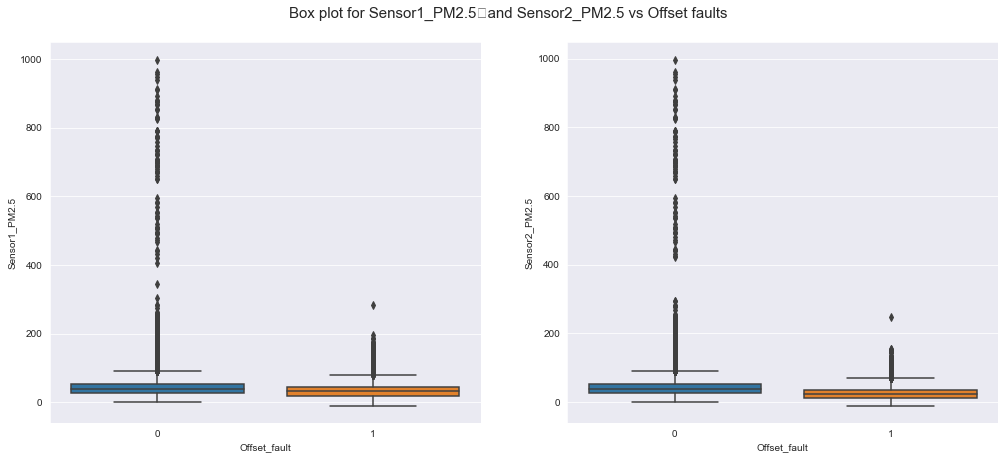

In [322]:
# Box plots for Sensor1_PM2.5	and Sensor2_PM2.5 vs Offset faults
sns.set_style('darkgrid')
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (17, 7))
fig.suptitle('Box plot for Sensor1_PM2.5	and Sensor2_PM2.5 vs Offset faults', y= 0.95, fontsize = 15)

for ax, data, name in zip(axes.flatten(), train, ['Sensor1_PM2.5', 'Sensor2_PM2.5']):
  sns.boxplot(train.Offset_fault, train[name], ax= ax)

 - Sensor 1 and sensor 2 are highly correlated with majority of the non faulty observations having the highest number of outliers

<a name="Correlations"></a>
## 8. Correlations - EDA

<Figure size 1440x864 with 0 Axes>

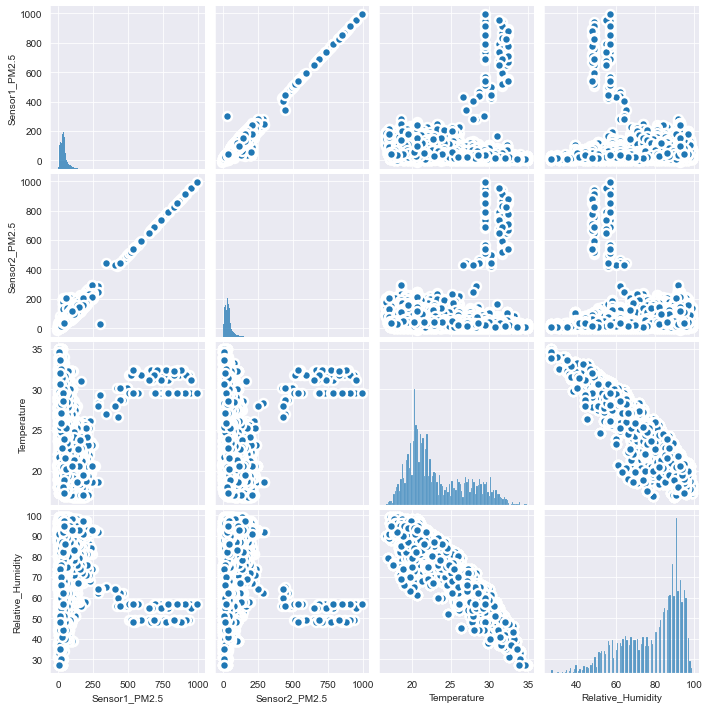

In [323]:
# Type of correlations 
plt.figure(figsize = (20, 12))
num_cols = ['Sensor1_PM2.5',	'Sensor2_PM2.5',	'Temperature',	'Relative_Humidity']
sns.pairplot(train[num_cols], kind="scatter", plot_kws=dict(s=80, edgecolor="white", linewidth=2.5))
plt.show()

 - There is a positive correlation between Sensor1_PM2.5	Sensor2_PM2.5
 - There is a negative correlation between temperature and humidity
 - There seems to be no correlation between sensor PM2.5 and temperature/humidity

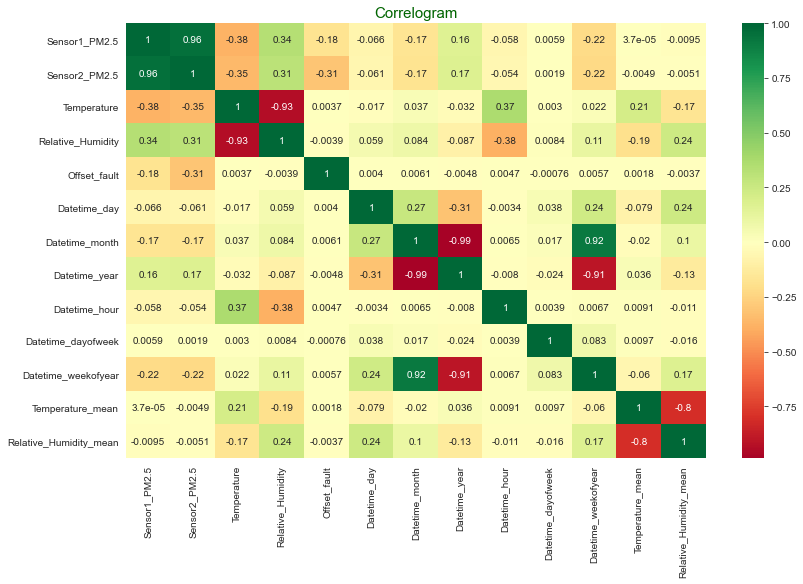

In [324]:
# Quantify correlations
corr = train.corr()
plt.figure(figsize = (13, 8))
sns.heatmap(corr, cmap='RdYlGn', annot = True, center = 0)
plt.title('Correlogram', fontsize = 15, color = 'darkgreen')
plt.show()

- There is a 0.96 positive correlation between sensor1 PM2.5 and sensor2 PM2.5
- There is a -0.99 negative correlation between temperature and humidity

<a name="Preprocess"></a>
## 9.  Preprocess test dataset

In [318]:
# test

In [325]:
# replace above by dropping Temperature and relative humidity
test.columns

Index(['ID', 'Datetime', 'Sensor1_PM2.5', 'Sensor2_PM2.5', 'Temperature',
       'Relative_Humidity', 'Datetime_day', 'Datetime_month', 'Datetime_year',
       'Datetime_hour', 'Datetime_dayofweek', 'Datetime_weekofyear',
       'Temperature_mean', 'Relative_Humidity_mean'],
      dtype='object')

In [326]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297177 entries, 0 to 297176
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   ID                      297177 non-null  object        
 1   Datetime                297177 non-null  datetime64[ns]
 2   Sensor1_PM2.5           297177 non-null  float64       
 3   Sensor2_PM2.5           297177 non-null  float64       
 4   Temperature             297177 non-null  float64       
 5   Relative_Humidity       297177 non-null  float64       
 6   Offset_fault            297177 non-null  int64         
 7   Datetime_day            297177 non-null  int64         
 8   Datetime_month          297177 non-null  int64         
 9   Datetime_year           297177 non-null  int64         
 10  Datetime_hour           297177 non-null  int64         
 11  Datetime_dayofweek      297177 non-null  int64         
 12  Datetime_weekofyear     297177

<a name="Modelling"></a>
## 10.  Modelling

In [339]:
# Selecting the independent variables and the target variable
train_feats = ['Sensor1_PM2.5',	'Sensor2_PM2.5', 'Datetime_day',
               'Datetime_month', 'Datetime_year', 'Datetime_hour', 'Datetime_dayofweek', 'Datetime_weekofyear', 'Temperature', 'Relative_Humidity']

X = train[train_feats]
y = train.Offset_fault

# dealing with imbalanced data
# X, y = SMOTE().fit_resample(X, y)

In [ ]:
# multiple models
classifiers = []
scores = []

In [342]:


# X = X.drop(['Temperature', 'Relative_Humidity'])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0,)

# RFC
# clf = RandomForestClassifier(max_depth = 3, random_state = 0)
# clf.fit(X_train, y_train)

# Logistic Regression
clf = LogisticRegression(class_weight = 'balanced')
clf.fit(X_train, y_train)

# Catboost
# clf = CatBoostClassifier(iterations = 1000, learning_rate = 0.1, depth = 3, loss_function = 'Logloss', random_seed = 0)

# Making predictions
y_pred = clf.predict(X_test)

# Measuring the accuracy of the model
print(f'Accuracy score: {accuracy_score(y_test, y_pred)}')
print('\n')
print(f'{classification_report(y_test, y_pred)}')

Accuracy score: 0.8926127823765619


              precision    recall  f1-score   support

           0       0.94      0.88      0.91     55966
           1       0.82      0.91      0.86     33188

    accuracy                           0.89     89154
   macro avg       0.88      0.90      0.89     89154
weighted avg       0.90      0.89      0.89     89154



In [312]:
# X.shape, y.shape

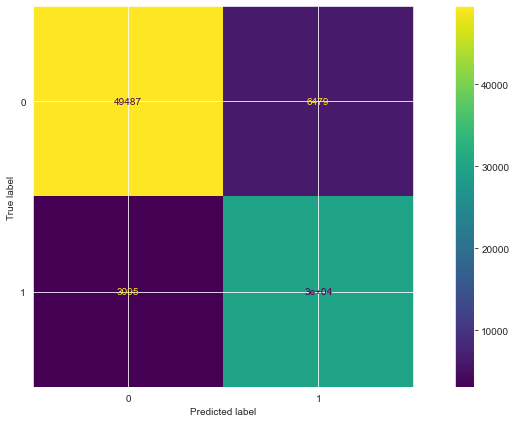

In [343]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(15,7))
disp.plot(ax=ax)
plt.show()

In [345]:
# Feature importance
# impo_df = pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).set_index('feature').sort_values(by = 'importance', ascending = False)
# impo_df = impo_df[:12].sort_values(by = 'importance', ascending = True)
# impo_df.plot(kind = 'barh', figsize = (10, 10), color = 'purple')
# plt.legend(loc = 'center right')
# plt.title('Bar chart showing feature importance', color = 'indigo', fontsize = 14)
# plt.xlabel('Features', fontsize = 12, color = 'indigo')
# plt.show()

# Train with all data

In [346]:
# Instantiating the model | better to predict & submit with the whole data
# clf = RandomForestClassifier(max_depth = 3, random_state = 0)
# clf.fit(X, y)

clf = LogisticRegression(class_weight = 'balanced')
clf.fit(X, y)

LogisticRegression(class_weight='balanced')

<a name="Predictions"></a>
## 11. Making predictions of the test set and creating a submission file

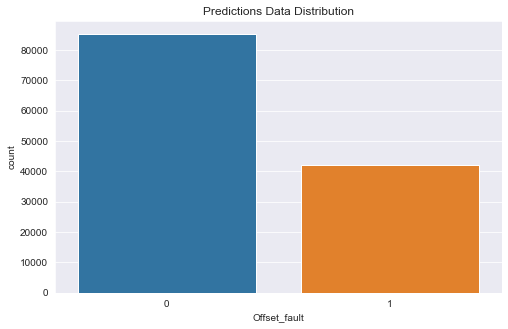

In [347]:
# Make prediction on the test set
# test_feats = ['Sensor1_PM2.5',	'Sensor2_PM2.5', 'Datetime_day', 'Datetime_month', 'Datetime_year', 'Datetime_hour', 'Datetime_dayofweek', 'Datetime_weekofyear']
test_df = test[train_feats]
predictions = clf.predict(test_df)

# # Create a submission file
sub_file = samplesubmission.copy()
sub_file.Offset_fault = predictions

# Check the distribution of your predictions
plt.figure(figsize=(8, 5))
sns.countplot(sub_file.Offset_fault)
plt.title('Predictions Data Distribution');

 - Majority of the model predictions are 0

In [ ]:
# weighting imbalanced class
# clf = RandomForestClassifier(max_depth = 3, random_state = 0, class_weight = 'balanced')

In [348]:
# Create file
sub_file.to_csv('Baseline4.csv', index = False)

<a name="Tips"></a>
##12. TO DOs

1. Generate more features, you can work on aggregating the columns( e.g mean temperature , mean humidity  etc)
2. For the datetime you can generate more features, day of the week, week of the year ...
3. Perform more EDA to get a better Understanding of the data, 
4. Try other classifier models
5. Experiment with different startegies of handling the missing values




## ALL THE BEST! 